In [11]:
# -*- coding: utf-8 -*-
#  Copyright 2024 -  United Kingdom Research and Innovation
#  Copyright 2024 -  The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by:    Margaret Duff (STFC-UKRI)
# 

# CIL Preconditioner and step size methods demonstration 


In [12]:
from cil.utilities import dataexample
from cil.utilities.display import show2D
from cil.recon import FDK
from cil.processors import TransmissionAbsorptionConverter, Slicer
import numpy as np
import matplotlib.pyplot as plt 
from cil.plugins.tigre import ProjectionOperator
from cil.optimisation.algorithms import GD
from cil.optimisation.functions import LeastSquares, L2NormSquared
from cil.optimisation.operators import MatrixOperator
from cil.optimisation.utilities import callbacks, StepSizeMethods, preconditioner
from cil.framework import  VectorData


# set up default colour map for visualisation
cmap = "gray"

# set the backend for FBP and the ProjectionOperator
device = 'gpu'



## Load Data

In this example, we utilize CIL's simulated sphere data. To accelerate computations in this notebook, we extract a 2D slice from the 3D dataset. Additionally, we select a subset of angles to create a limited-angle reconstruction scenario. We will then compare the ground truth data with a filtered back projection (FBP) reconstruction under these limited-angle conditions.

FDK recon

Input Data:
	angle: 60
	horizontal: 128

Reconstruction Volume:
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 8
	Filter_inplace: False



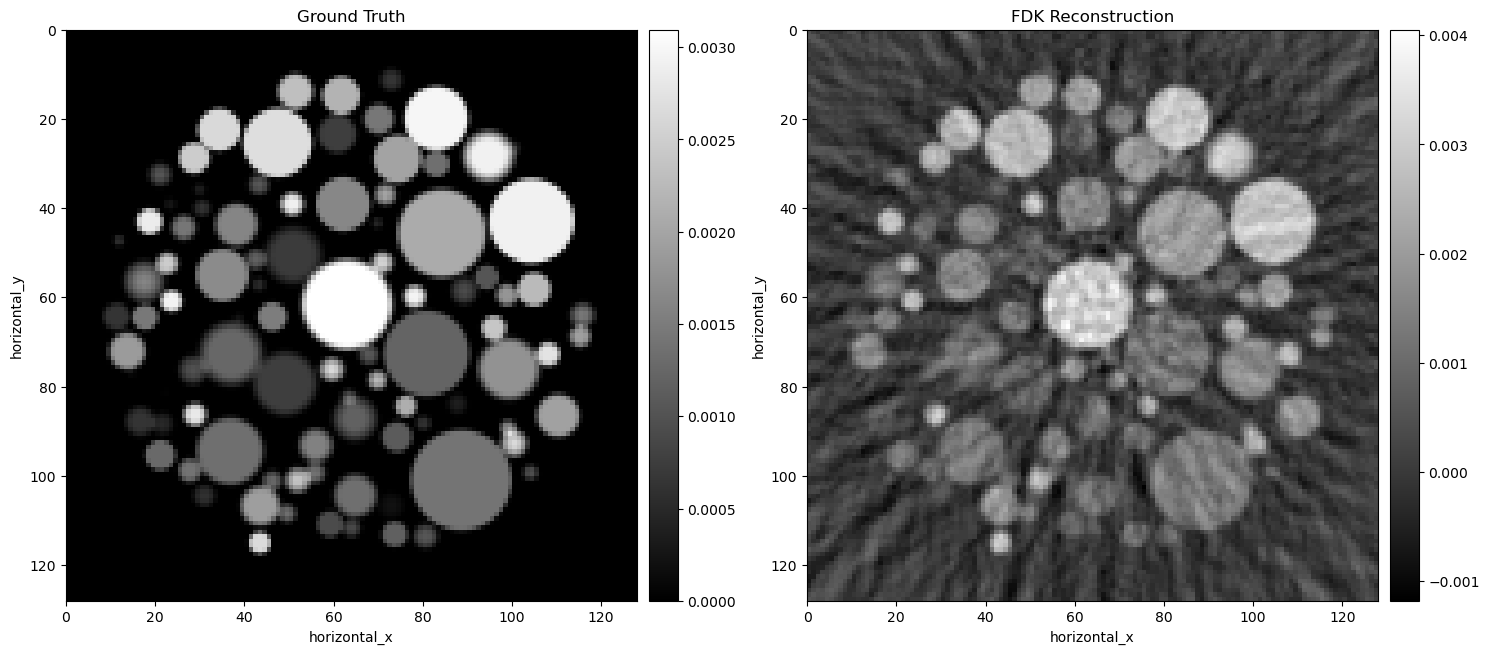

In [13]:
ground_truth = dataexample.SIMULATED_SPHERE_VOLUME.get()

data = dataexample.SIMULATED_CONE_BEAM_DATA.get()

data = data.get_slice(vertical='centre')
ground_truth = ground_truth.get_slice(vertical='centre')

absorption = TransmissionAbsorptionConverter()(data)
absorption = Slicer(roi={'angle':(0, -1, 5)})(absorption)

ig = ground_truth.geometry

recon = FDK(absorption, image_geometry=ig).run()
show2D([ground_truth, recon], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2)


## Gradient descent with a fixed step size 

We first consider regularising this limited angle CT reconstruction problem with Tikhonov regularisation:
$$ \arg\min_x \|Ax-y\|_2^2 + \alpha \|x\|_2^2 $$ 
where $x$ is the image we wish to reconstruct, $A$ the forward CT operator and $y$ the measured data. The regularisation parameter $\alpha$ is chosen to balance the first, data discrepancy, term and the second, regularisation, term. 

As a starting point, consider solving this optimisation problem with an arbitrary fixed step size, 1e-8.

  0%|          | 0/50 [00:00<?, ?it/s]

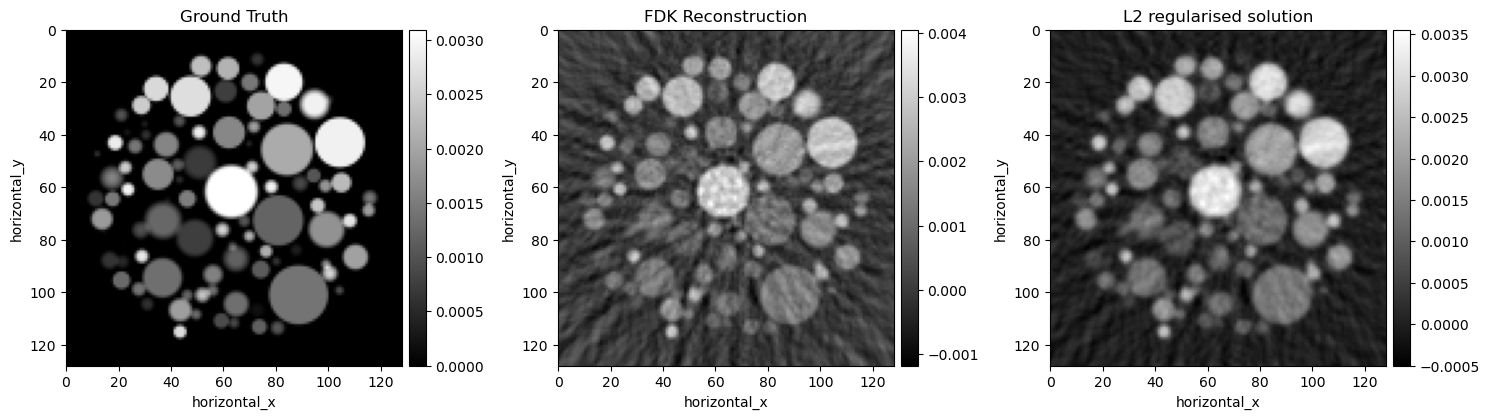

In [40]:
alpha=0.1   
A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)

F = 0.5*LeastSquares(A = A, b = absorption)+ alpha*L2NormSquared()
algo_GD_fixed=GD(initial=ig.allocate(0), objective_function=F, step_size=1e-6)
algo_GD_fixed.run(50)
show2D([ground_truth, recon, algo_GD_fixed.solution], title = ['Ground Truth', 'FDK Reconstruction', 'L2 regularised solution'], origin = 'upper', num_cols = 3)


We now plot the objective value, $\|Ax-y\|_2^2 + \alpha \|x\|_2^2$, against iteration number to look at the speed of convergence of this algorithm. 

Text(0, 0.5, 'Objective value')

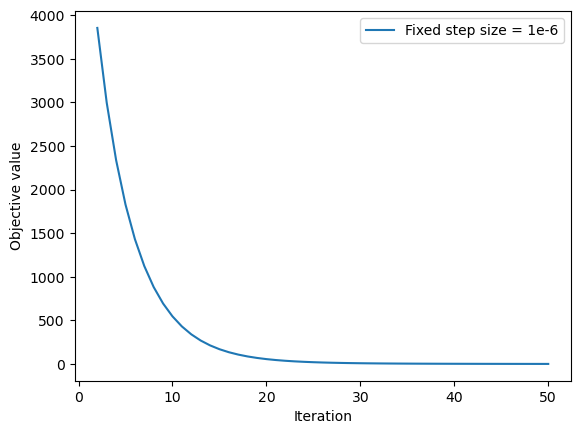

In [41]:
plt.plot(range(2,51),algo_GD_fixed.objective[2:], label='Fixed step size = 1e-6')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Objective value')

Now consider a more sensible choice of fixed step size, the reciprocal of the Lipschitz constant of $\|Ax-y\|_2^2 + \alpha \|x\|_2^2$.

  0%|          | 0/50 [00:00<?, ?it/s]

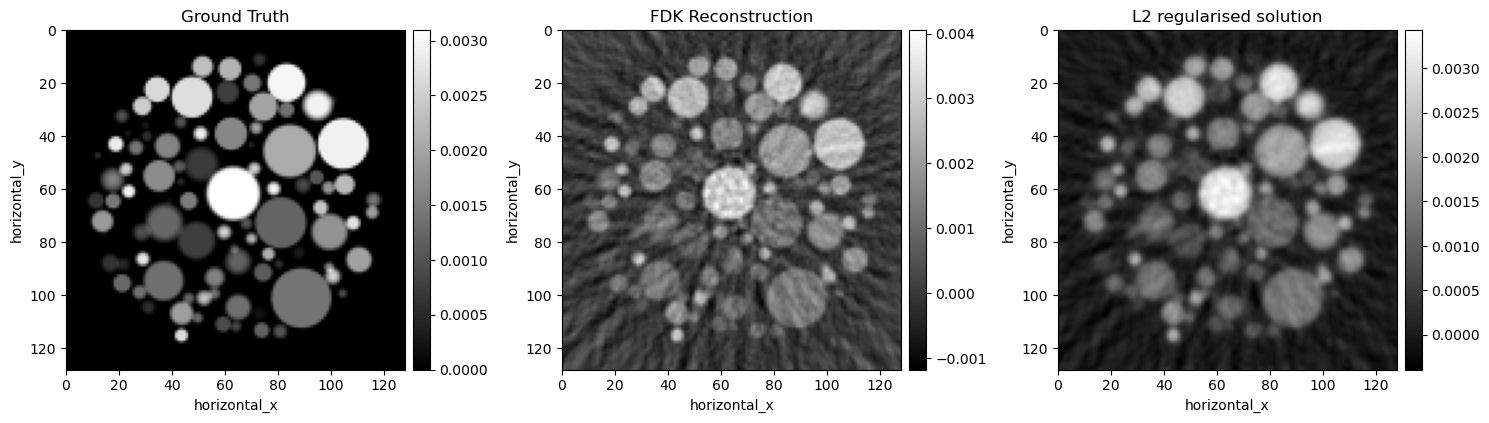

In [42]:

algo_GD_lip=GD(initial=ig.allocate(0), objective_function=F, step_size=1/F.L )
algo_GD_lip.run(50)
show2D([ground_truth, recon, algo_GD_lip.solution], title = ['Ground Truth', 'FDK Reconstruction', 'L2 regularised solution'], origin = 'upper', num_cols = 3)


Comparing the two step size choices, we can see that the reciprocal of the Lipschitz constant provides faster convergence rates: 

Text(0, 0.5, 'Objective value')

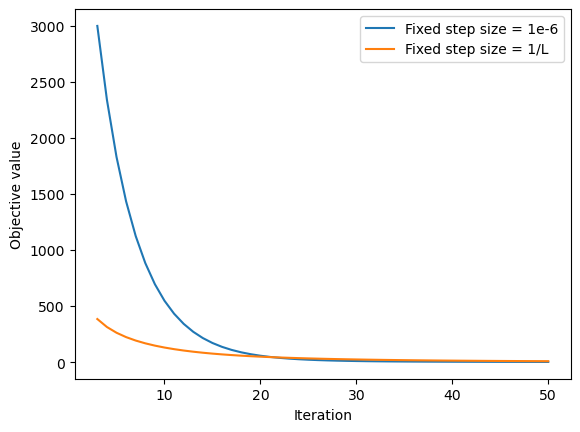

In [44]:
plt.plot(range(2,51),algo_GD_fixed.objective[2:], label='Fixed step size = 1e-6')
plt.plot(range(2,51),algo_GD_lip.objective[2:], label='Fixed step size = 1/L')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Objective value')

## Gradient descent default behaviour 

The default behaviour of gradient descent is to use the Armijo step size rule. This is a "backtracking" line search method that iteratively reduces the step size until a sufficient decrease in the objective function is achieved. The Armijo rule ensures that the step size chosen at each iteration satisfies the condition:

$$ f(x_k + \alpha_k \nabla f(x_k)) \leq f(x_k) + c \alpha_k \nabla f(x_k)^T f(x_k) $$

where $ f $ is the objective function, $ x_k $ is the current point, $ \alpha_k $ is the step size, $\nabla f(x_k)$ is the search direction, and $c $ is a constant typically chosen in the interval $ (0, 1) $. This condition guarantees that the step size provides a sufficient decrease in the objective function, balancing between making progress and ensuring stability in the optimization process.


/tmp/ipykernel_3422615/2081805095.py:6: DeprecationWarning: To modify the parameters for the Armijo rule please use `step_size_rule=ArmijoStepSizeRule(alpha, beta, kmax)`. The arguments `alpha` and `beta` will be deprecated. 
  algo_default=GD(initial=ig.allocate(0), objective_function=F , alpha=1e8)


  0%|          | 0/50 [00:00<?, ?it/s]

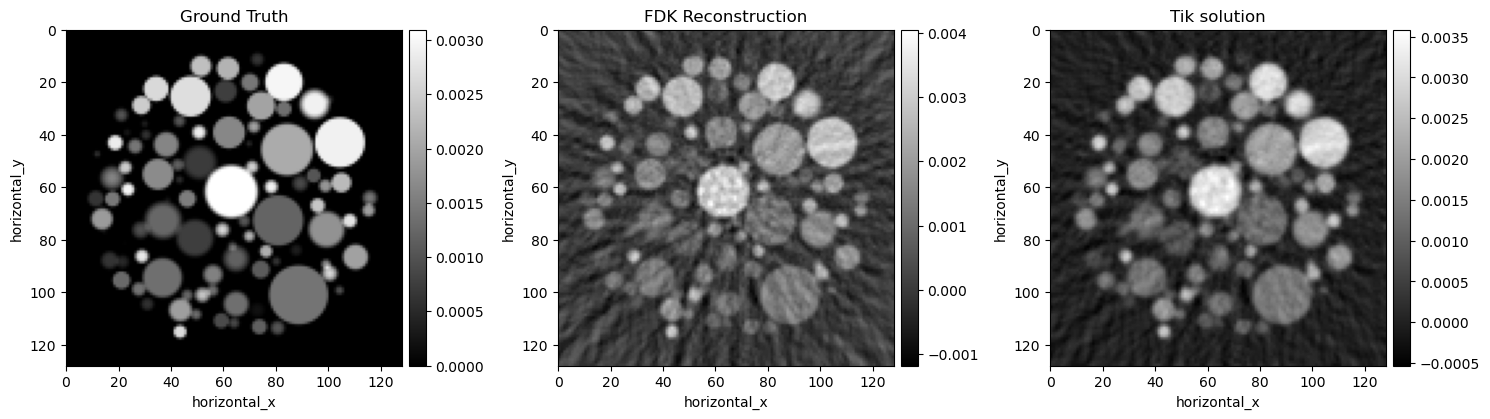

In [16]:
alpha=0.1
A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)

F = 0.5*LeastSquares(A = A, b = absorption)+ alpha*L2NormSquared()
algo_default=GD(initial=ig.allocate(0), objective_function=F , alpha=1e8) # TODO: once #1934 is merged remove the alpha argument
algo_default.run(50)
show2D([ground_truth, recon, algo_default.solution], title = ['Ground Truth', 'FDK Reconstruction', 'Tik solution'], origin = 'upper', num_cols = 3)


This does not work because in 40 iterations, the Armijo step size rule as not found a suitable step size. We can alter the number of iterations in the step size rule to allow it to run without error: 

Text(0, 0.5, 'Objective value')

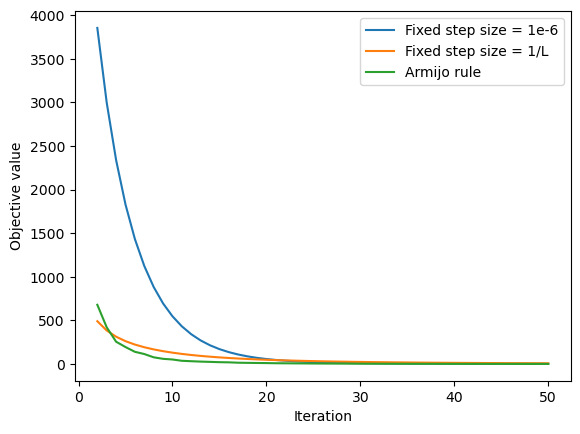

In [45]:
plt.plot(range(2,51),algo_GD_fixed.objective[2:], label='Fixed step size = 1e-6')
plt.plot(range(2,51),algo_GD_lip.objective[2:], label='Fixed step size = 1/L')
plt.plot(range(2,51),algo_default.objective[2:], label='Armijo rule')
plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Objective value')

We see faster convergence for the default step size rule, with the Armijo backtracking. 

## Gradient descent custom step size rule 


The `shrinking_step_size` class is a custom implementation of a step size rule for optimization algorithms, inheriting from the `StepSizeMethods.StepSizeRule` base class. This class defines a step size that decreases multiplicatively with each iteration of the algorithm, which can be useful for ensuring convergence in iterative optimization methods.

Constructor:
- `__init__(self, initial=0.1, shrinkage=0.999)`: Initializes the step size rule with an initial step size and a shrinkage factor.
  - `initial` (float): The initial step size to be used in the first iteration. Default is `0.1`.
  - `shrinkage` (float): The factor by which the step size is multiplied at each iteration. Default is `0.999`.

Methods:
- `get_step_size(self, algorithm)`: Computes the step size for the current iteration of the algorithm.
  - `algorithm` (object): The optimization algorithm instance, which is expected to have an `iteration` attribute indicating the current iteration number.
  - Returns: The step size for the current iteration, calculated as `initial * shrinkage^iteration`.

This class is particularly useful in scenarios where a gradually decreasing step size is desired to ensure that the optimization algorithm makes smaller adjustments as it approaches a solution, thereby improving stability and convergence. It is also useful in cases where the Lipschitz constant is not available or expensive to calculate. 

  0%|          | 0/50 [00:00<?, ?it/s]

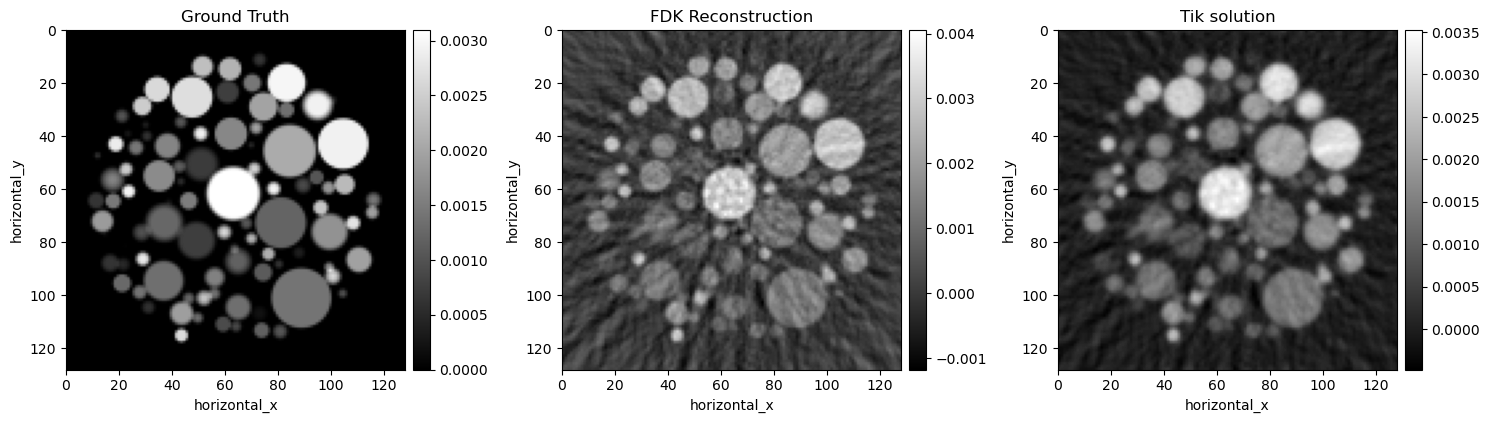

In [55]:
class shrinking_step_size(StepSizeMethods.StepSizeRule):
    def __init__(self, initial=0.1, shrinkage=0.99):
        self.shrinkage=shrinkage
        self.initial=initial
    
    def get_step_size(self, algorithm):
        return self.initial*self.shrinkage**algorithm.iteration
    
alpha=0.1
A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)

F = 0.5*LeastSquares(A = A, b = absorption)+ alpha*L2NormSquared()
algo_custom=GD(initial=ig.allocate(0), objective_function=F, step_size=shrinking_step_size(initial=1e-6) )
algo_custom.run(50)
show2D([ground_truth, recon, algo_custom.solution], title = ['Ground Truth', 'FDK Reconstruction', 'Tik solution'], origin = 'upper', num_cols = 3)


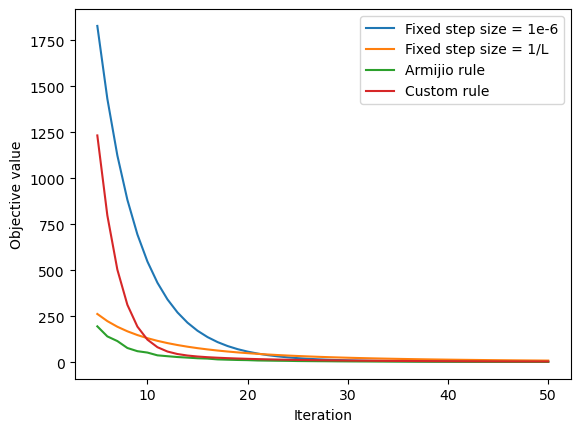

In [54]:
plt.plot(range(5,51),algo_GD_fixed.objective[5:], label='Fixed step size = 1e-6')
plt.plot(range(5,51),algo_GD_lip.objective[5:], label='Fixed step size = 1/L')
plt.plot(range(5,51),algo_default.objective[5:], label='Armijio rule')
plt.plot(range(5,51),algo_custom.objective[5:], label='Custom rule')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()

We see that within 15 iterations, the custom step size rule is able to achieve a similar objective value to the Armijo rule, without the additional calculations of the objective and without knowing the Lipschitz constant.

# Preconditioners 

To explain the concept of preconditioners, first look at the following toy problem. 

Consider solving, $$Ax^*=b$$ such that  $b=(0,0)^T$, $A=\begin{pmatrix}
1 & 0.3 \\
0 & 0.1 
\end{pmatrix}$. 

The unique solution to this is $x^*=(0,0)^T$. 

To visualise this problem we can plot $f(x)=\| Ax-b\|_2^2 and see the minimum point at (0,0):

Text(0, 0.5, 'x1')

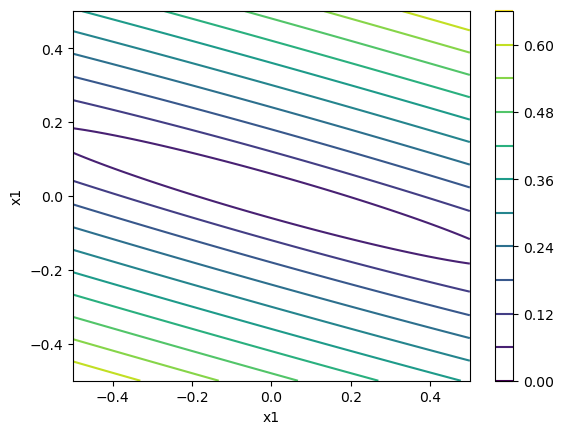

In [59]:
def f(x,y):
    return np.linalg.norm(np.matmul(np.array([[1,0.3],[0, 0.1]]), np.array([x,y]))-np.array([0,0]))
plt.figure()

x_ = np.linspace(-0.5, 0.5, num=200)
y_ = np.linspace(-0.5, 0.5, num=200)
x,y = np.meshgrid(x_, y_)

levels = np.zeros((200,200))
for i in range(200):
    for j in range(200):
        levels[i,j]=f(x_[i],y_[j])

c = plt.contour(x, y, levels, 10)
plt.colorbar()
plt.xlabel('x1')
plt.ylabel('x2')

We can solve this by gradient descent, minimising $f(x)=\| Ax-b\|_2^2. 

In [ ]:
initial = VectorData(np.array([1,2]))
b = VectorData(np.array([0,0]))
A = MatrixOperator(np.array([[1.,0.3],[0.01, 0.1]]))
F = 0.5*LeastSquares(A = A, b = b)

algo=GD(initial=initial, objective_function=F, step_size=1/F.L)
algo.run(10)



We precondition by the sensitivity of the matrix $A$ given by a vector $1/(A^T \mathbf{1})$

In [13]:
precon=preconditioner.Sensitivity(operator=MatrixOperator(np.array([[1,0.3],[0.01, 0.1]])))


Text(0, 0.5, 'y1')

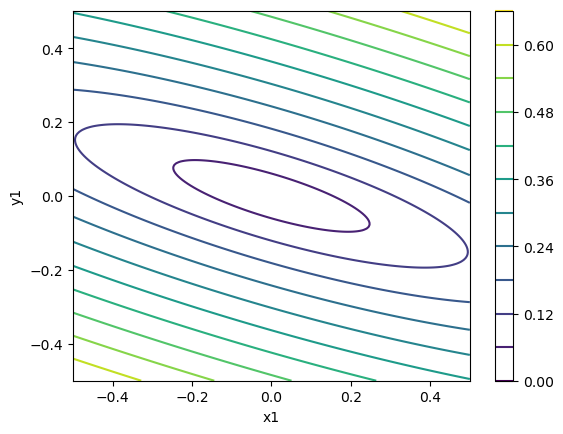

In [14]:
def f(x,y):
    return np.linalg.norm(precon.array.as_array()*(np.matmul(np.array([[1,0.3],[0.01, 0.1]]), np.array([x,y]))-np.array([0,0])))
plt.figure()

x_ = np.linspace(-0.5, 0.5, num=200)
y_ = np.linspace(-0.5, 0.5, num=200)
x,y = np.meshgrid(x_, y_)

levels = np.zeros((200,200))
for i in range(200):
    for j in range(200):
        levels[i,j]=f(x_[i],y_[j])

c = plt.contour(x, y, levels, 10)
plt.colorbar()
plt.xlabel('x1')
plt.ylabel('y1')

In [15]:
alpha=0.1
A = MatrixOperator(np.array([[1.,0.3],[0.01, 0.1]]))
b=VectorData(np.array([0.,0.]))

F = 0.5*LeastSquares(A = A, b = b)

algo=GD(initial=VectorData(np.array([0.,1.])), objective_function=F, step_size=1/F.L)
algo.run(300)

algo_precon=GD(initial=VectorData(np.array([0.,1.])), objective_function=F, preconditioner=preconditioner.Sensitivity(operator=A), step_size=1/F.L)
algo_precon.run(300)



  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [16]:
algo_precon.solution.as_array()

array([-0.0012519 ,  0.00407944])

In [17]:
algo.solution.as_array()

array([-0.0257575 ,  0.08484398])

The preconditioned gradient descent converges quicker:

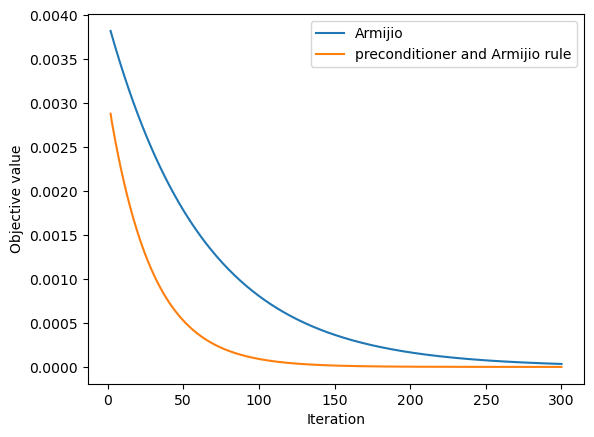

In [18]:
plt.plot(range(2,301),algo.objective[2:], label='Armijio')
plt.plot(range(2,301),algo_precon.objective[2:], label='preconditioner and Armijio rule')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()

Using a callback, we can see the progress of the algorithm and we see that the initial steps of the preconditioned algorithm get is much closer than in the unconditioned case. 

In [19]:
class save_solutions(callbacks.Callback):
    def __init__(self):
        self.solutions=[np.array([0.,1.])]
    
    def __call__(self, algorithm):
        self.solutions.append(algorithm.solution.as_array().copy())
        
callback_no_precon=save_solutions()
algo=GD(initial=VectorData(np.array([0.,1.])), objective_function=F, step_size=1/F.L)
algo.run(300,callbacks=[callback_no_precon])


callback_precon=save_solutions()
algo_precon=GD(initial=VectorData(np.array([0.,1.])), objective_function=F, preconditioner=preconditioner.Sensitivity(operator=A), step_size=1/F.L)
algo.run(300,callbacks=[callback_precon])


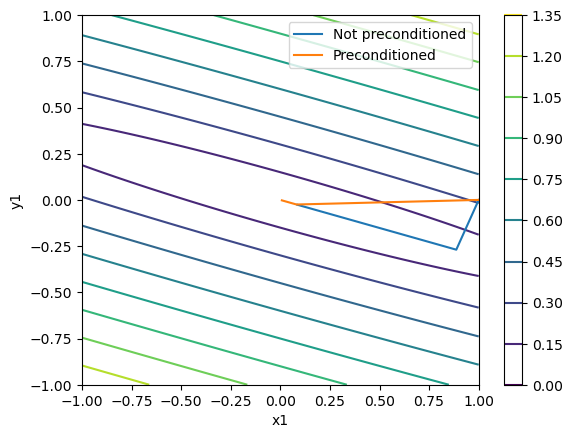

In [20]:
def f(x,y):
    return np.linalg.norm(np.matmul(np.array([[1,0.3],[0, 0.1]]), np.array([x,y]))-np.array([0,0]))

plt.figure()

x_ = np.linspace(-1, 1, num=200)
y_ = np.linspace(-1, 1, num=200)
x,y = np.meshgrid(x_, y_)

levels = np.zeros((200,200))
for i in range(200):
    for j in range(200):
        levels[i,j]=f(x_[i],y_[j])

c = plt.contour(x, y, levels, 10)
plt.colorbar()
plt.xlabel('x1')
plt.ylabel('y1')



plt.plot(np.array(callback_no_precon.solutions)[::5,1], np.array(callback_no_precon.solutions)[::5,0], label='Not preconditioned')
plt.plot(np.array(callback_precon.solutions)[::5,1], np.array(callback_precon.solutions)[::5,0], label='Preconditioned')
plt.legend()

In [21]:
#TODO: Can we go on to explain this in terms of length of rays in the CT case?? What does preconditioned by sensitivity mean for CT? 